# Block DCT (Discrete Cosine Transform)

How to color compress images using the DCT.

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import image_3 as image
import image_1 as component
import block_DCT as DCT
import YCoCg as YUV
#import RGB as YUV
import cv2
import distortion
import os
import pylab
import information
import deadzone as Q
import math

## First ... some handy routines

In [2]:
def read_image(prefix):
    x = image.read(prefix, 0)
    if len(x.shape) == 2:
        extended_x = np.zeros(shape=(x.shape[0],  x.shape[1], 3), dtype=np.uint16) 
        extended_x[..., 0] = x
        return extended_x
    else:
        return x

def PNG_BPP(_image, prefix):
    image.write(_image, prefix, 0)
    fn = prefix + "000.png"
    codestream_length = os.path.getsize(fn)
    BPP = (8*codestream_length)/np.size(_image)
    if __debug__:
        __image = image.read(prefix, 0)
        return BPP, __image
    else:
        return BPP, None

def write_image(x, prefix):
    if len(x.shape) == 3:
        Y = x[..., 0]
        Y_len = image.save(Y, prefix + '_Y_', 0)
        U_donwsampled = cv2.pyrDown(x[..., 1])
        U_len = image.save(U_downsampled, prefix + '_U_', 0)
        V_downsampled = cv2.pyrDown(x[..., 2])
        V_len = image.save(V_downsampled, prefix + '_V_', 0)
        total_len = Y_len + U_len + V_len
    else:
        total_len = image.save(x, image_fn, 0)
    return (8*total_len)/np.size(x)

## Global parameters of the notebook

In [3]:
#test_image = "../sequences/stockholm/"
test_image = "../sequences/lena_color/"
#test_image = "../sequences/lena_bw/"

In [4]:
block_y_side = block_x_side = 8

In [5]:
N_components = 3

## Testing `block_DCT.analyze_block()` and `block_DCT.synthesize_block()`

The DCT concentrates the energy of the signal in a few coefficients.

In [6]:
#a = np.random.randint(low=0, high=100, size=(4,4,3))
a = np.full(shape=(4,4,3), fill_value=10, dtype=np.int16)

In [7]:
print(a)

[[[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


In [8]:
b = DCT.analyze_block(a)

In [9]:
print(b.astype(np.int16))

[[[40 40 40]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]

 [[ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]
  [ 0  0  0]]]


The DCT is reversible.

In [10]:
c = DCT.synthesize_block(b)

In [11]:
print(c.astype(np.int16))

[[[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]

 [[10 10 10]
  [10 10 10]
  [10 10 10]
  [10 10 10]]]


## Testing `DCT.analyze_image()` and `DCT.synthesize_image()`

image_3.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
component 0 255 54 uint8
component 1 248 1 uint8
component 2 239 8 uint8


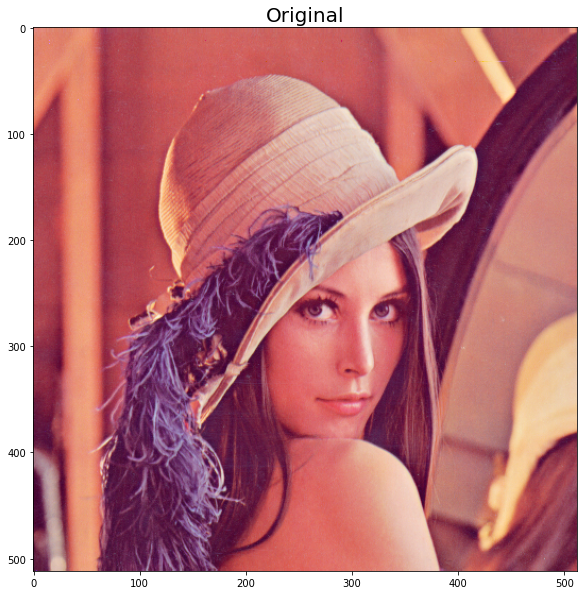

In [12]:
x = image.read(test_image, 0)
image.show(x, title="Original")

In [13]:
y = DCT.analyze_image(x, block_y_side, block_x_side)

component 0 1.0 0.025669085 float32
component 1 0.8931591 0.0 float32
component 2 0.839591 0.051004898 float32
component 0 1.0 0.02401697 float32
component 1 0.65297234 0.0 float32
component 2 0.5463294 0.024998164 float32


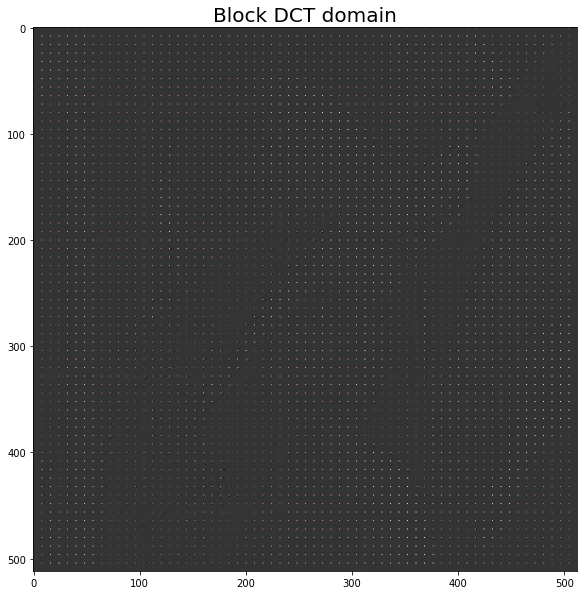

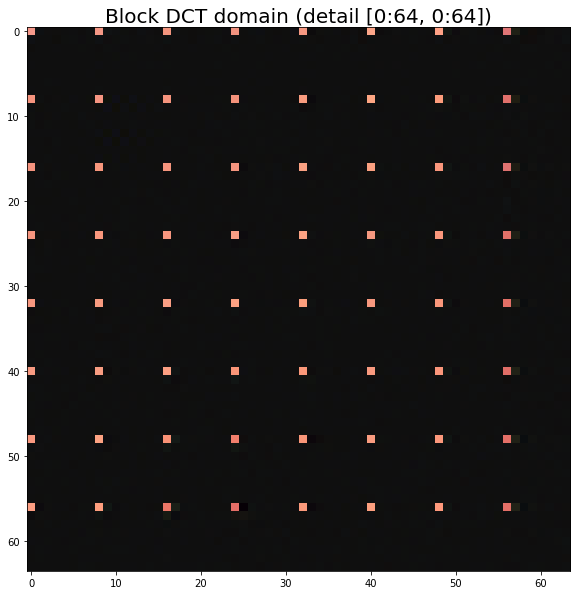

In [14]:
image.show(image.normalize(y), "Block DCT domain")
image.show(image.normalize(y[:64, :64]), "Block DCT domain (detail [0:64, 0:64])")

Again, most of the energy of each block has been concentrated in the low-pass frequency component (DC component).

In [15]:
z = DCT.synthesize_image(y, block_y_side, block_x_side)

In [16]:
r = x - z

component 0 1.0 0.0 float64
component 1 1.0 0.0 float64
component 2 1.0 0.0 float64


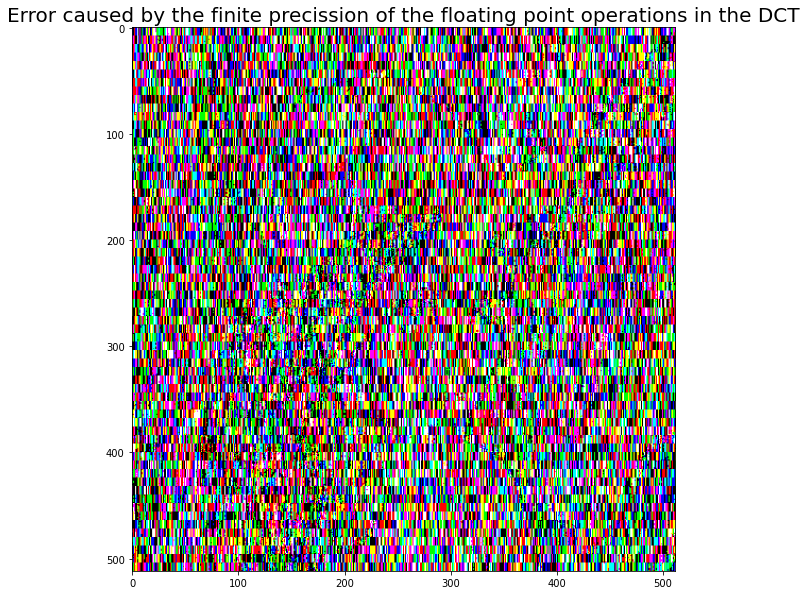

In [17]:
image.show(image.normalize(r), "Error caused by the finite precission of the floating point operations in the DCT")

Remember that this image has been normalized to the range [0, 255]

In [18]:
print(r.max(), r.min())

1 0


Therefore, the DCT is not fully reversible, but it is almost. Compare the dynamic range of the components of the reconstruction to the original ones.

component 0 255 54 int16
component 1 247 0 int16
component 2 239 7 int16


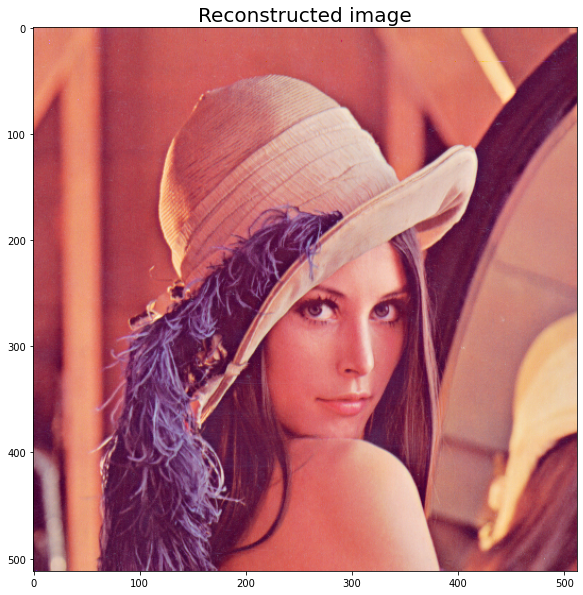

In [19]:
image.show(z, "Reconstructed image")

## Switching between blocks and subbands

The coefficients of the block-DCT can be reorganized in subbands. A subband with corrdinates (X, Y) is the 2D concatenation of the coefficients that is in the coordinates (X, Y) of each block. The representation in subbands increases the spatial correlation between the coefficients (provides an improved visual comprehension of the image in the frequency domain).

In [20]:
x = read_image(test_image)
y = DCT.analyze_image(x, block_y_side, block_x_side)
y_subbands = DCT.get_subbands(y, block_y_side, block_x_side)

image_3.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 


component 0 1.0 0.025669085 float32
component 1 0.8931591 0.0 float32
component 2 0.839591 0.051004898 float32


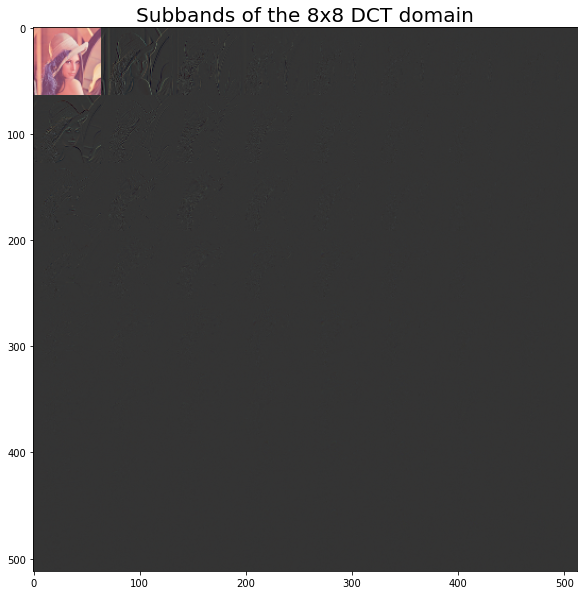

In [21]:
image.show(image.normalize(y_subbands), f"Subbands of the {block_y_side}x{block_x_side} DCT domain")

Reording the coefficients into subbands is completely reversible.

In [22]:
yy = DCT.get_blocks(y_subbands, block_y_side, block_x_side)
(yy == y).all()

True

And it can be seen, the 2D correlation is higher in the low frequencies (left up corner) than in the high frequencies (right down corner).

component 0 1.0 0.2699343 float32
component 1 0.86010563 0.0 float32
component 2 0.7899652 0.17886126 float32


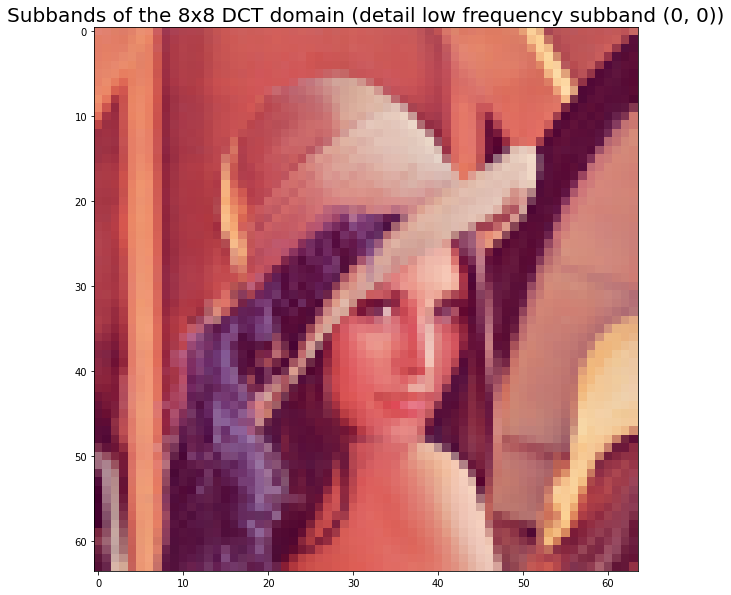

In [23]:
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
image.show(image.normalize(y_subbands[:blocks_in_y, :blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail low frequency subband (0, 0))")

component 0 0.90172267 0.05342205 float32
component 1 1.0 0.0 float32
component 2 0.7881435 0.16321258 float32


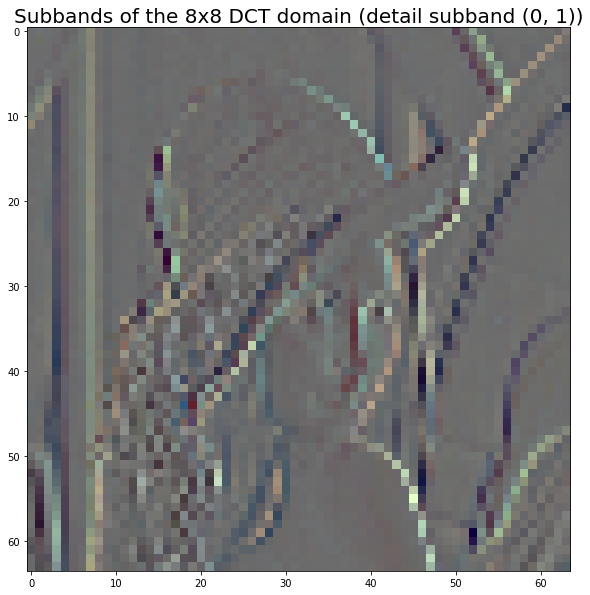

In [24]:
image.show(image.normalize(y_subbands[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail subband (0, 1))")

The (0, 1) subband represents slow changes of signal in the horizontal domain.

component 0 0.92079896 0.06307283 float32
component 1 1.0 0.0 float32
component 2 0.8885713 0.10595121 float32


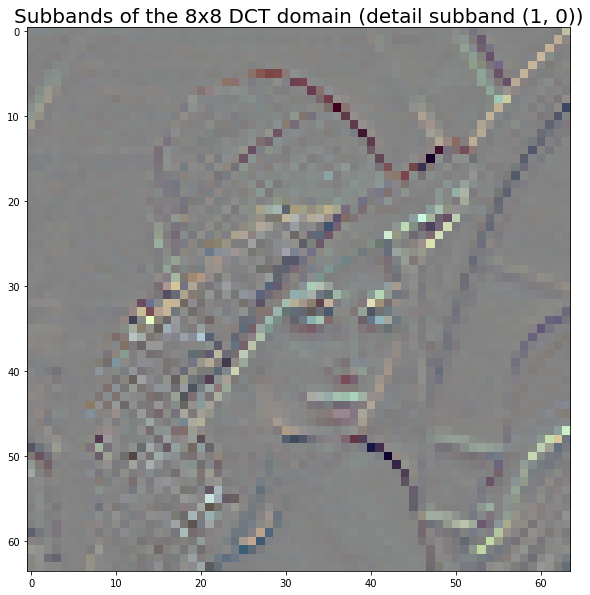

In [25]:
image.show(image.normalize(y_subbands[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail subband (1, 0))")

The (1, 0) subband represents slow changes of signal in the vertical domain.

component 0 0.9280892 0.10813528 float32
component 1 1.0 0.0 float32
component 2 0.84966314 0.16063201 float32


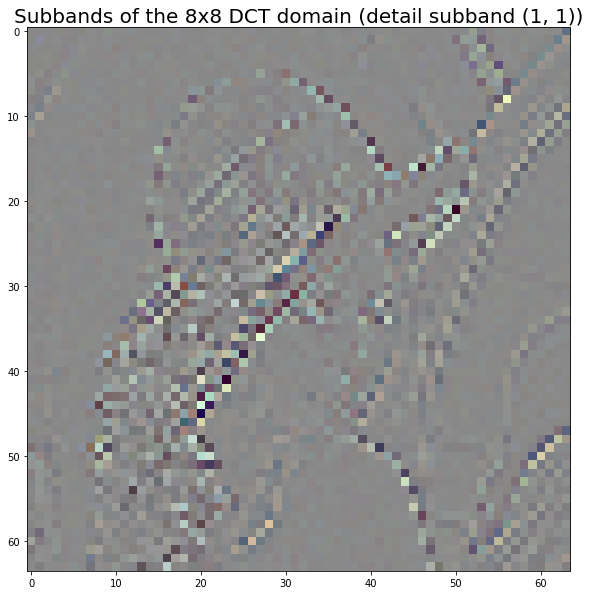

In [26]:
image.show(image.normalize(y_subbands[blocks_in_y:2*blocks_in_y, blocks_in_x:2*blocks_in_x]), f"Subbands of the {block_y_side}x{block_x_side} DCT domain (detail subband (1, 1))")

The (1, 1) subband represents slow changes of signal in the diagonal (left up corner to right down corner) domain.

## Subbands/components information

In [28]:
x = image.read(test_image, 0)
xx = YUV.from_RGB(x.astype(np.int16) - 128) # -128 decreases maximum value of the DC coefficients
#xx = YUV.from_RGB(x.astype(np.int16))
yy = DCT.analyze_image(xx, block_y_side, block_x_side)
yy = DCT.get_subbands(yy, block_y_side, block_x_side)
print("   sb component maximum mininum max-min average std-dev entropy        energy  avg-enegy")
accumulated_entropy = 0
blocks_in_y = x.shape[0] // block_y_side
blocks_in_x = x.shape[1] // block_x_side
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for c in range(N_components):
            sbc = yy[blocks_in_y*_y:blocks_in_y*(_y+1),
                     blocks_in_x*_x:blocks_in_x*(_x+1),
                     c]
            entropy = information.entropy(sbc.flatten().astype(np.int16))
            accumulated_entropy += entropy
            max = sbc.max()
            min = sbc.min()
            d_range = max - min
            print(f"{_y:2d} {_x:2d} {c:9d} {max:7.1f} {min:7.1f} {d_range:7.1f} {np.average(sbc):7.1f} {math.sqrt(np.var(sbc)):7.1f} {entropy:7.1f} {information.energy(sbc):13.1f} {information.energy(sbc)/sbc.size:10.1f}")
avg_entropy = accumulated_entropy / (block_x_side * block_y_side * xx.shape[2])
print("Average entropy in the cosine domain:", avg_entropy)
print("Entropy in the image domain:", information.entropy(x.flatten().astype(np.uint8)))

image_3.read: ../sequences/lena_color/000.png (512, 512, 3) uint8 512673 
   sb component maximum mininum max-min average std-dev entropy        energy  avg-enegy
 0  0         0   728.0  -720.2  1448.2   -56.3   335.4    10.0   473817465.8   115678.1
 0  0         1   520.0   -64.1   584.1   297.3   137.3     8.9   439317864.4   107255.3
 0  0         2    34.2  -305.6   339.9  -172.2    67.1     7.6   139936012.5    34164.1
 0  1         0   604.4  -424.2  1028.7    -1.7    81.3     7.6    27058261.7     6606.0
 0  1         1   143.2  -198.4   341.6     0.0    24.0     6.1     2356139.7      575.2
 0  1         2   104.7  -118.8   223.5    -0.3    15.6     5.2      991104.1      242.0
 0  2         0   275.0  -261.6   536.6     1.1    38.0     6.3     5933955.0     1448.7
 0  2         1    85.1   -73.4   158.5     0.2    10.9     5.0      489508.8      119.5
 0  2         2    65.3   -81.4   146.6     0.1     7.9     4.2      256941.3       62.7
 0  3         0   166.7  -273.3   44

As it can be observed, the DCT accumulates most of the energy in the low-frequency subbands. Moreover (after a rounding operation) the entropy is also decreased significantly.

## Quantization steps

Considering the previous dynamic range values for the YCoCg/8x8-DCT coefficients, this parameter should allow to use 8 bits/pixel images, if we are using PNG as an entropy codec. As it can be seen, we need 11 bits for representing the DC coefficients (notice that we have substracted 128 to the image to reduce in one bit the number of bits of the low frequency subband) and after quantization, we should use only 8. Therefore, the minimum quantization step should be 1<<3 = 8.

In [ ]:
Q_steps = [128, 64, 32, 16, 8]

## Testing `DCT.uniform_quantize()` and `DCT.uniform_dequantize()` NO
Quantization removes information but also increases the compression ratios of the stored images. These methods quantize all coefficients with the same quantization step.

In [ ]:
Q_step = 128
x = image.read(test_image, 0)
xx = YUV.from_RGB(x.astype(np.int16) - 128)
yy = DCT.analyze_image(xx, block_y_side, block_x_side)
yy = DCT.get_subbands(yy, block_y_side, block_x_side)
yy_k = DCT.uniform_quantize(yy, block_y_side, block_x_side, N_components, Q_step)
yy_dQ = DCT.uniform_dequantize(yy_k, block_y_side, block_x_side, N_components, Q_step)
yy_dQ = DCT.get_blocks(yy_dQ, block_y_side, block_x_side)
zz_dQ = DCT.synthesize_image(yy_dQ, block_y_side, block_x_side)
z_dQ = YUV.to_RGB(zz_dQ) + 128
image.show(np.clip(z_dQ, a_min=0, a_max=255), f"Quantized image (Q_step={Q_step}) in the {block_y_side}x{block_x_side} DCT YUV domain")

In [ ]:
r = x - z_dQ
n = image.normalize(r)
image.show(n, "Quantization error")

Quantization in the DCT domain tends to remove high frequencies (it works basically as a low pass filter).

## Coding subbands vs coding blocks
Let's see the effect of encoding the DCT coefficients grouped by subbands. For simplicity, we will use uniform quantization.

In [ ]:
x = image.read(test_image, 0)
xx = YUV.from_RGB(x.astype(np.int16) - 128)

RD_points_blocks = []
RD_points_subbands = []
for Q_step in Q_steps:
    yy = DCT.analyze_image(xx, block_y_side, block_x_side)
    # Notice that with uniform_quantize() does not matter if the DCT domain
    # is organized in subbands or blocks.
    yy_k = DCT.uniform_quantize(yy, block_y_side, block_x_side, N_components, Q_step)
    #BPP, _y_Q = information.PNG_BPP((y_Q.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_")
    #assert (y_Q == _y_Q.astype(np.int32) - 32768).all()
    BPP = image.write((yy_k + 128).astype(np.uint8), f"/tmp/{Q_step}_", 0)*8/xx.size
    __ = image.read(f"/tmp/{Q_step}_", 0)
    try:
        assert ((yy_k + 128) == __).all()
    except AssertionError:
        counter = 0
        for _i in range(x.shape[0]):
            for _j in range(x.shape[1]):
                if (yy_k[_i, _j] != __[_i, _j]).any():
                    print(yy_k[_i, _j], __[_i, _j])
                    if counter > 10:
                        break
                    counter += 1
            if counter > 10:
                break
    yy_dQ = DCT.uniform_dequantize(yy_k, block_y_side, block_x_side, N_components, Q_step)
    zz_dQ = DCT.synthesize_image(yy_dQ, block_y_side, block_x_side)
    z_dQ = YUV.to_RGB(zz_dQ) + 128
    # Notice that to compute the distortion, the DCT domain could be
    # also used.
    MSE = distortion.MSE(x, z_dQ)
    RD_points_blocks.append((BPP, MSE))
    yy_k_subbands = DCT.get_subbands(yy_k, block_y_side, block_x_side)
    #BPP, _yy_k_subbands = information.PNG_BPP((yy_k_subbands.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/s_{Q_step}_")
    #assert (yy_k_subbands == _yy_k_subbands.astype(np.int32) - 32768).all()
    BPP = image.write((yy_k_subbands + 128).astype(np.uint8), f"/tmp/{Q_step}_", 0)*8/xx.size
    __ = image.read(f"/tmp/{Q_step}_", 0)
    try:
        assert ((yy_k_subbands + 128) == __).all()
    except AssertionError:
        counter = 0
        for _i in range(x.shape[0]):
            for _j in range(x.shape[1]):
                if (yy_k_subbands[_i, _j] != __[_i, _j]).any():
                    print(yy_k_subbands[_i, _j], __[_i, _j])
                    if counter > 10:
                        break
                    counter += 1
            if counter > 10:
                break
    RD_points_subbands.append((BPP, MSE))
    print(Q_step, end=' ', flush=True)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_blocks), label=f"{block_y_side}x{block_x_side} DCT (encoded by blocks)")
pylab.plot(*zip(*RD_points_subbands), label=f"{block_y_side}x{block_x_side} DCT (encoded by subbands)")
pylab.title("")
pylab.xlabel("BPP")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

## Can we do it better?

Let's compute the optimal sequence of quantization steps for the set of possible combinations of subbands and components. We will compute the distortion of each subband-component in the YCoCg/8x8-DCT domain for a set of quantization steps, considering that the YCoCg transform is near-orthogonal and that the 8x8-DCT is full-orthogonal.

Algorithm:
1. Read the image.
2. Transform to the YCoCg domain.
3. Transform each component to the 8x8-DCT domain.
4. Find the RD curve for each subband-component.
5. Compute the slope of each step of each curve and put all the slopes in the same list.
6. Sort the previous list by the slope field.
7. FInd the RD curve that progressively uses decending slopes.

In [ ]:
# Read the image and move to the YCoCg domain.
x = image.read(test_image, 0)
xx = YUV.from_RGB(x.astype(np.int16) - 128)

In [ ]:
# Move to the 8x8-DCT domain.
yy = DCT.analyze_image(xx, block_y_side, block_x_side)
yy = DCT.get_subbands(yy, block_y_side, block_x_side)

In [ ]:
# Create a list of RD points and a list of RD slopes.
# The first dimension is the subband-compoent and the second
# dimension is the point of the operational RD curve
# of the subband-component.
RD_points = []
RD_slopes = []
N_components = xx.shape[2]
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            sbc = yy[blocks_in_y*_y:blocks_in_y*(_y+1),
                     blocks_in_x*_x:blocks_in_x*(_x+1),
                     _c]
            sbc_energy = information.average_energy(sbc) # Change to .energy()
            # The first point of each RD curve has a maximum distortion equal
            # to the energy of the subband and a rate = 0
            RD_points.append([(0, sbc_energy)])
            RD_slopes.append([])

In [ ]:
# Now populate the rest of points of each subband.
# Distortion is measured in the transform domain.
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            sbc = yy[blocks_in_y*_y:blocks_in_y*(_y+1),
                     blocks_in_x*_x:blocks_in_x*(_x+1),
                    _c]
            counter = 0
            for Q_step in Q_steps:
                sbc_k = Q.quantize(sbc, Q_step)
                sbc_dQ = Q.dequantize(sbc_k, Q_step)
                MSE = distortion.MSE(sbc, sbc_dQ)
                BPP = component.write(sbc_k.astype(np.uint8), f"/tmp/{_y}_{_x}_{Q_step}_", 0)*8/xx.size
                #BPP_Q_indexes = information.PNG_BPP((Q_indexes.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
                #BPP_Q_indexes = information.entropy(Q_indexes.astype(np.int16).flatten())
                point = (BPP, MSE)
                RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c].append(point)
                print("Q_step =", Q_step, "BPP =", point[0], "MSE =", point[1])
                delta_BPP = BPP - RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c][counter][0]
                delta_MSE = RD_points[(_y * block_x_side * N_components + _x * N_components ) + _c][counter][1] - MSE
                if delta_BPP > 0:
                    slope = delta_MSE/delta_BPP
                else:
                    slope = 0
                RD_slopes[(_y * block_x_side * N_components + _x * N_components) + _c].append((Q_step, slope, (_y, _x, _c)))
                counter += 1

In [ ]:
print(RD_slopes)

RD_slopes_without_sb_index = []
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            RD_slopes_without_sb_index.append([])
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for _c in range(N_components):
            for Q_step in range(len(Q_steps)):
                #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
                index = (_y * block_x_side * N_components + _x * N_components) + _c
                RD_slopes_without_sb_index[index].append(RD_slopes[index][Q_step][0:2])

if block_y_side < 4:
    pylab.figure(dpi=150)
    for _y in range(block_y_side):
        for _x in range(block_x_side):
            for _c in range(N_components):
                index = (_y * block_x_side * N_components + _x * N_components) + _c
                pylab.plot(*zip(*RD_slopes_without_sb_index[index]), label=f"{_y} {_x} {_c}", marker=f"{i+1}")
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
# Sort the slopes
single_list = []
for _y in range(block_y_side):
    for _x in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            for _c in range(N_components):
                #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
                index = (_y * block_x_side * N_components + _x * N_components) + _c
                single_list.append(tuple(RD_slopes[index][Q_step]))
                
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [ ]:
sorted_slopes

In [ ]:
# Find the optimal RD curve
optimal_RD_points = []
yy_prog = np.zeros_like(yy)
Q_steps_combination = np.full(shape=(block_x_side, block_y_side, N_components), fill_value=99999999)
for s in sorted_slopes:
    sbc_index = s[2]
    _y = sbc_index[0]
    _x = sbc_index[1]
    _c = sbc_index[2]
    print(_y, _x, _c)
    Q_steps_combination[_y, _x, _c] = s[0]
    print(sbc_index, Q_steps_combination[_y, _x, _c])
    yy_prog[blocks_in_y*_y:blocks_in_y*(_y+1),
            blocks_in_x*_x:blocks_in_x*(_x+1),
            _c] = yy[blocks_in_y*_y:blocks_in_y*(_y+1),
                     blocks_in_x*_x:blocks_in_x*(_x+1),
                     _c]
    yy_prog_k = DCT.quantize(yy_prog, Q_steps_combination)
    yy_prog_dQ = DCT.dequantize(yy_prog_k, Q_steps_combination)
    yy_prog_dQ = DCT.get_blocks(yy_prog_dQ, block_y_side, block_x_side)
    zz_prog = DCT.synthesize_image(yy_prog_dQ, block_y_side, block_x_side)
    # If the color transform domain is not linear, the MSE should be measured in the RGB domain
    MSE = distortion.MSE(xx, zz_prog)
    #BPP, _y_quant = information.PNG_BPP((y_quant.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{i}_{j}_{Q_step}_")
    #assert (y_quant == _y_quant.astype(np.int32) - 32768).all()
    BPP = image.write((yy_prog_k + 128).astype(np.uint8), f"/tmp/{_y}_{_x}_{_c}_{s[0]}_", 0)*8/xx.size
    point = (BPP, MSE)
    print("Q_step =", s[0], "BPP =", BPP, "MSE =", MSE)
    optimal_RD_points.append(point)

In [ ]:
JPEG_RD_points = []
with open("JPEG.txt", 'r') as f:
    for line in f:
        rate, _distortion = line.split('\t')
        JPEG_RD_points.append((float(rate), float(_distortion)))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RD_points_subbands), label="uniform quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.plot(*zip(*JPEG_RD_points), label="JPEG")
pylab.title("Comparing with JPEG")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
with open('DCT.txt', 'w') as f:
    for item in optimal_RD_points:
        f.write(f"{item[0]}\t{item[1]}\n")

## Except for some proofs, ignore the rest

## Which color domain is better?

Let's plot RD curves.

In [ ]:
x = read_image(test_image).astype(np.int16) - 128

RGB_points = []
for Q_step in Q_steps:
    y = DCT.analyze_image(x, block_y_side, block_x_side)
    y_k = DCT.uniform_quantize(y, block_y_side, block_x_side, Q_step)
    y_k_subbands = DCT.get_subbands(y_k, block_y_side, block_x_side)
    #BPP, _y_k = information.PNG_BPP((y_k_subbands.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_")
    #assert (y_k_subbands == _y_k.astype(np.int32) - 32768).all()
    BPP = image.write(y_k_subbands.astype(np.uint8) + 128, f"/tmp/RGB_{Q_step}_", 0)*8/x.size
    __ = image.read(f"/tmp/RGB_{Q_step}_", 0).astype(np.int16) - 128
    try:
        assert (y_k_subbands == __).all()
    except AssertionError:
        counter = 0
        for _i in range(x.shape[0]):
            for _j in range(x.shape[1]):
                if (y_k_subbands[_i, _j] != __[_i, _j]).any():
                    print(y_k_subbands[_i, _j], __[_i, _j])
                    if counter > 10:
                        break
                    counter += 1
            if counter > 10:
                break
    y_dQ = DCT.uniform_dequantize(y_k, block_y_side, block_x_side, Q_step)
    z_dQ = DCT.synthesize_image(y_dQ, block_y_side, block_x_side)
    MSE = distortion.MSE(x, z_dQ)
    point = (BPP, MSE)
    print(point)
    RGB_points.append(point)

In [ ]:
x = image.read(test_image, 0)

RGB_points = []
for Q_step in Q_steps:
    x_k = Q.quantize(x, Q_step)
    x_dQ = Q.dequantize(x_k, Q_step)
    BPP = image.write(x_k.astype(np.uint8), f"/tmp/RGB_{Q_step}_", 0)*8/x.size
    __ = image.read(f"/tmp/RGB_{Q_step}_", 0)
    assert (x_k == __).all()
    MSE = distortion.MSE(x, x_dQ)
    point = (BPP, MSE)
    print(point)
    RGB_points.append(point)

In [ ]:
#xx = read_image(test_image).astype(np.int16) - 128
xx = image.read(test_image, 0).astype(np.int16) - 128
#xx = image.read(test_image, 0).astype(np.int16)
x = YUV.from_RGB(xx)
#x = YUV.from_RGB(xx.astype(np.int16) - 128)

YUV_points = []
for Q_step in Q_steps:
    y = DCT.analyze_image(x, block_y_side, block_x_side)
    y_k = DCT.uniform_quantize(y, block_y_side, block_x_side, Q_step)
    y_k_subbands = DCT.get_subbands(y_k, block_y_side, block_x_side)
    #BPP, _y_k = information.PNG_BPP((y_k_subbands.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_")
    #assert (y_k_subbands == _y_k.astype(np.int32) - 32768).all()
    BPP = image.write(y_k_subbands.astype(np.uint8) + 128, f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    __ = image.read(f"/tmp/YUV_{Q_step}_", 0).astype(np.int16) - 128
    try:
        assert (y_k_subbands == __).all()
    except AssertionError:
        counter = 0
        for i in range(x.shape[0]):
            for j in range(x.shape[1]):
                if (y_k_subbands[i, j] != __[i, j]).any():
                    print(y_k_subbands[i, j], __[i, j])
                    if counter > 10:
                        break
                    counter += 1
            if counter > 10:
                break
    y_dQ = DCT.uniform_dequantize(y_k, block_y_side, block_x_side, Q_step)
    z_dQ = DCT.synthesize_image(y_dQ, block_y_side, block_x_side)
    zz_dQ = YUV.to_RGB(z_dQ)
    MSE = distortion.MSE(xx, zz_dQ)
    point = (BPP, MSE)
    print(point)
    YUV_points.append(point)

In [ ]:
x = image.read(test_image, 0)
xx = YUV.from_RGB(x.astype(np.int16))

YUV_points = []
for Q_step in Q_steps:
    xx_k = Q.quantize(xx, Q_step)
    xx_dQ = Q.dequantize(xx_k, Q_step)
    print(xx_k.dtype, xx_k.max(), xx_k.min())
    #BPP = image.write((xx_k.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #__ = image.read(f"/tmp/YUV_{Q_step}_", 0).astype(np.int32) - 32768
    #BPP = image.write((xx_k.astype(np.int16) + 128).astype(np.uint8), f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #__ = image.read(f"/tmp/YUV_{Q_step}_", 0).astype(np.int32) - 128
    BPP = image.write((xx_k + 128).astype(np.uint8), f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    __ = image.read(f"/tmp/YUV_{Q_step}_", 0).astype(np.int16) - 128
    #BPP = image.write(xx_k, f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #BPP = image.write((xx_k + 128).astype(np.uint8), f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #BPP = image.write(xx_k + xx_k.min(), f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #BPP = image.write(xx_k - xx.min(), f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #BPP = image.write(xx_k + 256, f"/tmp/YUV_{Q_step}_", 0)*8/x.size
    #for i in range(512):
    #    for j in range(512):
    #        if (xx_k[i,j] != __[i,j]).any():
    #            print(Q_step, i, j, x_k[i,j], __[i,j])
    #            break
    assert (xx_k == __).all()
    x_dQ = YUV.to_RGB(xx_dQ)
    MSE = distortion.MSE(x, x_dQ)
    point = (BPP, MSE)
    print(point)
    YUV_points.append(point)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*RGB_points), label="RGB")
pylab.plot(*zip(*YUV_points), label="YUV")
pylab.title("Which color domain is better?")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

The amount of distortion generated during the compression of an image is controlled the quantization. The DCT is a linear transform which preserves the energy, i.e., the quantization error (that can be considered as a random signal added to the original image) is the same in both the image and the transform domain (we will check that). Moreover, because the subbands generated by the DCT have the same gain (we will also check that), the uniform quantization of all the subbands generates the same amount of distortion in all the subbands. Notice that the quantization error depends mainly on the quantization step (not on the signal) when the dynamic range of the signal is significantly larger than the quantization step.

However, not always all the subbands are equally compressible. For example, if after a uniform amoung subbands quantization all the coefficients of a subband become zero or very close to this value (because the energy of this subband is small compared to the quantization step), the cost of representing such subband in the code-stream will be low. Therefore, even if the contribution of this subband to the quality of the reconstructed image is small compared to other subbands, the contribution of its compressed representation can be significative for the reconstruction of the image.

An important question that arises here is: are the contributions of the subbands to the quality of the reconstructed image independent? If the transform is orthogonal (something that we will check), the answer is yes. Thanks to this, we can assume that the quantization error generated in one subband does not influence on the quantization error added to the other subbands, and therefore, we can optimize (search) the quantization step in each subband, independently, by using the same slope in the R/D curve of the subband  (selecting the quantization step).

Remember that in the case of the DCT, each subband has the same gain (all the subbands generates the same quantization error when a uniform quantization step is used) and that the transform is energy preserving (the distortion can be measured equally in the image and the transform domain). Therefore, we can use the RD curves of the subbands that represents how the distortion of the subband decreases with the length of the code-stream of the subband. Thanks to this, we will not need to compute the inverse transform to compute the distortion.

For the sake of simplicity in the rest of experiments, we will only suppose that the available quantization steps are {128, 64, 32, 16, 8, 4, 2 and 1}. Usually, this produces a RD curve whose points are equally distant (more or less) in the rate domain.

## Determination of the operational RD curve of each subband

ESTE PASO NO ES NECESARIO: Compute the DCT and the average energy of the image.

In [ ]:
xx = read_image(test_image).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze_image(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = information.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(image_energy)
print(information.average_energy(y))

For each subband, we create a list of RD points and a list of RD slopes. These slopes are computed from the points.

In [ ]:
# Create a list of lists. The first dimension is the subband and the second
# dimension is the point of the operational RD curve of the subband.
RD_points = []
RD_slopes = []
for i in range(block_y_side):
    for j in range(block_x_side):
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        subband_energy = information.average_energy(sb)
        # The first point of each RD curve has a maximum distortion equal
        # to the energy of the subband and a rate = 0
        RD_points.append([(0, subband_energy)])
        RD_slopes.append([])
        
# Now populate the rest of points of each subband
for i in range(block_y_side):
    for j in range(block_x_side):
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        counter = 0
        for Q_step in Q_steps:
            print(Q_steps)
            Q_indexes = Q.quantize(sb, Q_step)
            Q_coefs = Q.dequantize(Q_indexes, Q_step)
            MSE_Q_coefs = distortion.MSE(sb, Q_coefs)
            BPP_Q_indexes = information.PNG_BPP((Q_indexes.astype(np.int32) + 32768).astype(np.uint16), "/tmp/BPP_")[0]
            #BPP_Q_indexes = information.entropy(Q_indexes.astype(np.int16).flatten())
            RD_points[i * block_x_side + j].append((BPP_Q_indexes, MSE_Q_coefs))
            delta_BPP = BPP_Q_indexes - RD_points[i * block_x_side + j][counter][0]
            delta_MSE = RD_points[i * block_x_side + j][counter][1] - MSE_Q_coefs
            if delta_BPP > 0:
                slope = delta_MSE/delta_BPP
            else:
                slope = 0
            RD_slopes[i * block_x_side + j].append((Q_step, slope, (i, j)))
            counter += 1

In [ ]:
if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_points[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("MSE")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_points[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("RD curves of the subbands")
    pylab.xlabel("Bits/Pixel")
    pylab.ylabel("MSE")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

As it can be seen (for small enough block sizes), the slopes of all the subband are approximately the same, except for the subband (0, 0). This result sugests that the subband (0, 0) should be encoded with the smaller quantization step than the rest of the subbands.

In [ ]:
subband = 0
Q_step_index = 0
RD_slopes[subband][Q_step_index][0:2]

In [ ]:
RD_slopes_without_sb_index = []
for i in range(block_y_side):
    for j in range(block_x_side):
        RD_slopes_without_sb_index.append([])
for i in range(block_y_side):
    for j in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
            RD_slopes_without_sb_index[i * block_x_side + j].append(RD_slopes[i * block_x_side + j][Q_step][0:2])

if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_slopes_without_sb_index[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    plt.legend(loc="best")
    pylab.show()

In [ ]:
if block_y_side < 8:
    pylab.figure(dpi=150)
    for i in range(block_y_side):
        for j in range(block_x_side):
            pylab.plot(*zip(*RD_slopes_without_sb_index[i * block_x_side + j]), label=f"{i} {j}", marker=f"{i+1}")
    pylab.title("Slopes of the RD curves of the subbands")
    pylab.xlabel("Q_step")
    pylab.ylabel("Slope")
    pylab.yscale("log")
    plt.legend(loc="best")
    pylab.show()

These results show that the subband that constributes the most to the quality of the reconstruction is [0, 0], followed by [0, 1] and [1, 0].

In [ ]:
RD_slopes

Let's sort the slopes.

In [ ]:
single_list = []
for i in range(block_y_side):
    for j in range(block_x_side):
        for Q_step in range(len(Q_steps)):
            #print(RD_slopes[i * block_x_side + j][Q_step][0:2])
            single_list.append(tuple(RD_slopes[i * block_x_side + j][Q_step]))

In [ ]:
sorted_slopes = sorted(single_list, key=lambda x: x[1])[::-1]

In [ ]:
sorted_slopes

As it can be seen, the uniform quantization step is not optimal, but it's performance is not bad because the sorted slopes are highly correlated with the quantization step.

Let's implement now the optimal quantization progression.

## Optimal quantization progression

Let's plot the optimal RD curve. Using the quantization steps defined in the list of sorted slopes, we will perform a reconstruction for each slope, measuring the distortion and the bit-rate.

In [ ]:
optimal_RD_points = []
y_prog = np.zeros_like(y_sbs)
Q_steps = np.full(shape=(block_x_side, block_y_side), fill_value=99999999)
for s in sorted_slopes:
    subband = s[2]
    i = subband[0]
    j = subband[1]
    Q_steps[i, j] = s[0]
    print(subband, Q_steps[i, j])
    y_prog[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)] = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                                                    blocks_in_x*j:blocks_in_x*(j+1)]
    y_quant = DCT.quantize(y_prog, block_y_side, block_x_side, Q_steps)
    y_dequant = DCT.dequantize(y_quant, block_y_side, block_x_side, Q_steps)
    y_dequant = DCT.get_blocks(y_dequant, block_y_side, block_x_side)
    z_prog = DCT.synthesize_image(y_dequant, block_y_side, block_x_side)
    # If the color transform domain is not linear, the MSE should be measured in the RGB domain
    MSE = distortion.MSE(x, z_prog)
    BPP, _y_quant = information.PNG_BPP((y_quant.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{i}_{j}_{Q_step}_")
    assert (y_quant == _y_quant.astype(np.int32) - 32768).all()
    optimal_RD_points.append((BPP, MSE))

Compute the RD curve for JPEG.

In [ ]:
import PIL

xx = image.read(test_image, 0).astype(np.uint8)
JPEG_RD_points = []
for q in range(75):
    im = PIL.Image.fromarray(xx)
    im.save("/tmp/1.jpeg", quality=q, subsampling=0) # No color subsampling
    BPP = os.path.getsize("/tmp/1.jpeg")*8/xx.size
    zz = np.asarray(PIL.Image.open("/tmp/1.jpeg"))
    MSE = distortion.MSE(xx, zz)
    JPEG_RD_points.append((BPP, MSE))
    print(BPP, MSE)

Compare:

# .................

## Chroma subsampling

Our codec is 4:4:4 and JPEG is 4:2:0. 

We apply a Sinc to the chroma and subsample. 

## Computation of the RD slopes

In [ ]:
print(RD_points)

## Fast optimal quantization



In [ ]:
for Q_step in range(len(Q_steps)):
    for i in range(block_y_side):
        for j in range(block_x_side):
            print(f"{RD_points[i * block_x_side + j][Q_step], end=' ')
    print()

In [ ]:
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        #zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

## Subband gains
The gain of each subband can be computed giving energy to a subband, performing the inverse transform, and measuring the energy of the reconstruction.

In [ ]:
blocks_in_y = 1024//block_y_side
blocks_in_x = 1024//block_x_side
y_only_one_sb = np.empty(shape=(1024, 1024))
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb[...] = 0.0
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = 100.0
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        energy = distortion.average_energy(z_only_one_sb)
        print(int(energy), end=' ')
    print()

As it can be seen, the 8x8 DCT has (approximately) the same gain for all the subbands and therefore, the uniform quantization is optimal from this point of view. Let's analyze now the information content of each subband.

## Dynamic range of the subbands
Some subbands (such as LL) has more energy than others. Notice, however, that energy is not equal to information.

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
max_, min_ = block_DCT.compute_max_min(y, block_y_side, block_x_side)

In [ ]:
np.set_printoptions(edgeitems=8, linewidth=120, formatter=dict(float=lambda x: "%.3g" % x))
print(max_.astype(np.int32))

In [ ]:
print(min_.astype(np.int32))

## Variances of the subbands
The variance in each subband, however, is a good estimator of the information provided the subband.

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
variances = block_DCT.compute_variances(y, block_y_side, block_x_side)

In [ ]:
np.set_printoptions(edgeitems=5, linewidth=100, formatter=dict(float=lambda x: "%.3g" % x))
print(variances.astype(np.int32))
print("max var =", variances.max(), "at", np.unravel_index(variances.argmax(), variances.shape))
print("min var =", variances.min(), "at", np.unravel_index(variances.argmin(), variances.shape))

As it can be seen, most of the information is stored in the low-frequency subbands.

## Quantizing depending on the variance
Lets quantize depending on the variance.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

variance_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    variances = np.sqrt(block_DCT.compute_variances(y, block_y_side, block_x_side))
    normalized_variances = (variances - variances.min()) / (variances.max() - variances.min())
    Q_steps = Q_step / np.log(normalized_variances + 1.01)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #image.write(q_y, f"/tmp/{Q_step}_", 0)
    image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    variance_RD_points.append((bits_per_pixel, MSE))
    print(Q_step)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*subband_RD_points), label="uniform quantization")
pylab.plot(*zip(*variance_RD_points), label="variance-based quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

As it can be seen, varying the quantization step depending on the variance does not necessarily improves significatively the R/D tradeoff. This is a consequence of that the subband gains are approximately the same and therefore, the quantization noise remains uniform among subbands.

## Quantizing depending on the variance with thresholding
Now, we set to zero all those quantization idexes that (in absolute value) are smaller than a threshold.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

threshold_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    variances = np.sqrt(block_DCT.compute_variances(y, block_y_side, block_x_side))
    normalized_variances = (variances - variances.min()) / (variances.max() - variances.min())
    Q_steps = Q_step / np.log(normalized_variances + 1.01)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    q_y[ abs(q_y) < 3] = 0 
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    #image.write(q_y, f"/tmp/{Q_step}_", 0)
    image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    threshold_RD_points.append((bits_per_pixel, MSE))
    print(Q_step)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*subband_RD_points), label="uniform quantization")
pylab.plot(*zip(*threshold_RD_points), label="variance-based quantization with threshold")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

And, as it can be seen, as it happens with a variable variance-based (wihtout thresholding) quantization step, the effect that we can reach lower bit-rates (obviously, increasing the distortion), although not better R/D tradeoffs.

## About the contribution of the subbands to the quality of the recostruction
Quantization can be also considered as a form of controlling how much information of the original image will be found in the reconstruction. Moreover, due to the DCT is orthogonal, DCT coefficients (and therefore, also the subbands) are uncorrelated, which implies that the contribution of each subband to the reconstruction is independent.

To check this we can:
1. Transform the image.
2. Generate the subbands.
3. Set to zero all the subband except one.
4. Restore the DCT-blocks.
5. Apply the inverse transform.
6. Transform the generated image.
7. Test if the resulting DCT image matches the DCT image used in the step 5. If matches (with some maximum error), the transform is orthogonal.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side

i_coordinate_to_keep = 1
j_coordinate_to_keep = 1
mask = np.zeros_like(y, bool)
mask[blocks_in_y*i_coordinate_to_keep:(blocks_in_y+1)*i_coordinate_to_keep,
     blocks_in_x*j_coordinate_to_keep:(blocks_in_x+1)*j_coordinate_to_keep] = True
y_sbs[~mask] = 0
y_blks = DCT.get_blocks(y_sbs, block_y_side, block_x_side)
y_blks_copy = np.copy(y_blks)
z = DCT.synthesize(y_blks, block_y_side, block_x_side)
y2 = DCT.analyze(z, block_y_side, block_x_side)
print((y2 == y_blks_copy).all())
print((y2[~mask] == 0).all())

Therefore, the DCT is orthogonal.

## R/D performance

## Is the B-DCT orthogonal (and orthonormal)?
Orthogonality implies that the contributions of the distortion of the subbands to the distortion of the reconstructed image are additive. Orthonormality that the contributions are the same.

## Contribution of each subband to the distortion of the reconstruction
The DCT is orthogonal. This means that the DCT coefficients are uncorrelated, or in other words, that the quantization error generated in one coefficient (or subband) is not correlated with the quantization error generated in other coefficients (or subbands).

Following this reasoaning, we can assume that the quantization noise

We perform the inverse transform of the subband decomposition considering only one subband (zeroing the rest) and measuring the MSE between the reconstructed image and the original one.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
MSE_l = []
entropy_l = []
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        #zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

In [ ]:
print("Entropy:")
for i in range(block_y_side):
    for j in range(block_x_side):
        entropy = entropy_l[i*block_x_side+j]
        print(f"{entropy:7.2f}", end=' ')
    print()
print("MSE:")
for i in range(block_y_side):
    for j in range(block_x_side):
        MSE = MSE_l[i*block_x_side+j]
        print(f"{MSE:7.2f}", end=' ')
    print()
print("MSE improvement:")
for i in range(block_y_side):
    for j in range(block_x_side):
        improvement = image_energy - MSE_l[i*block_x_side+j]
        print(f"{improvement:7.2f}", end=' ')
    print()
print("Slope:")
for i in range(block_y_side):
    for j in range(block_x_side):
        slope = (image_energy - MSE_l[i*block_x_side+j]) / entropy_l[i*block_x_side+j]
        print(f"{slope:7.2f}", end=' ')
    print()

It can be seen that the subband LL and its neighborhood contribute more to the quality of the reconstruction (in terms of R/D) than the others. These differences depends on the correlation between the original image and the (2D) basis functions corresponding to each subband.

## 

## A manual search of the optimal sequence of quantization steps per subband
For the sake of simpliticy, let's suppose that only the quantization steps [128, 54, 32, 16, 8, 4, 2, 1] are available. We will work only with 16 subbands, for the same reason.

This creates a search tree of nodes where each one represents a relative , where there is sequence of nodes

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(image_energy)


### Considering only L4L4.Q=128

In [ ]:
i = 0
j = 0
Q_step = 128
MSEs_LL = []
entropies_LL = []
y_progressive = np.zeros_like(y_sbs)
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
slope = (image_energy - MSE) / entropy
print("Delta MSE =", MSE, "Delta Entropy =", entropy, "Slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

### After S[0, 0].Q=128, considering S[0, 0].Q=64

In [ ]:
i = 0
j = 0
Q_step = 64
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
delta_MSE = MSEs_LL[0] - MSE
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
delta_entropy = entropy - entropies_LL[0]
slope = delta_MSE / delta_entropy
print("Delta MSE =", delta_MSE, "Delta_entropy =", delta_entropy, "slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

### After S[0, 0].Q=128, considering S[0, 1].Q=128

In [ ]:
i = 0
j = 0
Q_step = 128
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
i = 0
j = 1
Q_step = 128
sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
           blocks_in_x*j:blocks_in_x*(j+1)]
Q_sb = Q.dequantize(Q.quantize(sb, Q_step), Q_step)
y_progressive[blocks_in_y*i:blocks_in_y*(i+1),
              blocks_in_x*j:blocks_in_x*(j+1)] = Q_sb
y_blks_prog = DCT.get_blocks(y_progressive, block_y_side, block_x_side)
z_prog = DCT.synthesize(y_blks_prog, block_y_side, block_x_side)
MSE = distortion.MSE(x, z_prog)
delta_MSE = MSEs_LL[0] - MSE
entropy = information.entropy((Q_sb.astype(np.int16).flatten()))
delta_entropy = entropy - entropies_LL[0]
slope = delta_MSE / delta_entropy
print("Delta MSE =", delta_MSE, "Delta_entropy =", delta_entropy, "slope =", slope)
MSEs_LL.append(MSE)
entropies_LL.append(entropy)

In [ ]:
image_energy = distortion.average_energy(x) # DCT is unitary, i.e., energy(x) = energy(y)
print(distortion.average_energy(y))
MSE_l = []
entropy_l = []
for i in range(block_y_side):
    for j in range(block_x_side):
        y_only_one_sb = np.zeros_like(y_sbs)
        #only_one_subband_y = np.copy(y)
        sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                   blocks_in_x*j:blocks_in_x*(j+1)]
        y_only_one_sb[blocks_in_y*i:blocks_in_y*(i+1),
                      blocks_in_x*j:blocks_in_x*(j+1)] = sb
        y_only_one_sb_blks = DCT.get_blocks(y_only_one_sb, block_y_side, block_x_side)
        z_only_one_sb = DCT.synthesize(y_only_one_sb_blks, block_y_side, block_x_side)
        zz_only_one_sb = YUV.to_RGB(z_only_one_sb)
        MSE = distortion.MSE(x, z_only_one_sb)
        MSE_l.append(MSE)
        entropy = information.entropy((sb.astype(np.int16).flatten()))
        entropy_l.append(entropy)
        slope = (image_energy - MSE) / entropy
        print(i, j, image_energy, MSE, entropy, slope)

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = DCT.analyze(x, block_y_side, block_x_side)
y_sbs = DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side

print("Accumulated subband distortions:")
accum_RD_points = []
y_accum_sbs = np.zeros_like(y_sbs)
for i in range(block_y_side):
    for j in range(block_x_side):
        if i!=0 and j!=0:
            sb = y_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                       blocks_in_x*j:blocks_in_x*(j+1)]
            y_accum_sbs[blocks_in_y*i:blocks_in_y*(i+1),
                        blocks_in_x*j:blocks_in_x*(j+1)] = sb
            y_accum_sbs_blks = DCT.get_blocks(y_accum_sbs, block_y_side, block_x_side)
            z_accum_sbs = DCT.synthesize(y_accum_sbs_blks, block_y_side, block_x_side)
            zz_accum_sbs = YUV.to_RGB(z_accum_sbs)
            MSE = distortion.MSE(xx, zz_accum_sbs)
            print(i, j, MSE)
            accum_RD_points.append((i*block_y_side+j, MSE))

In [ ]:
pylab.figure(dpi=150)
subband_index = np.arange(0, block_y_side*block_x_side, 0.01)
pylab.plot(subband_index, 1/subband_index, label="1/x")
pylab.plot(*zip(*accum_RD_points), label="optimal quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("subband index")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In the case of the B-DCT, all subbands have a similar gain. Therefore, al subbands should be quantized with the same quantization step.

## R/D optimization
The quantization steps should operate in each subband with the same RD-slope.

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)

optimal_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    y = block_DCT.get_subbands(y, block_y_side, block_x_side)
    #slopes = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    Q_steps, slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_step)
    print(Q_steps.astype(np.int32))
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))
    print(Q_step, end=' ', flush=True)

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*variance_RD_points), label="variance quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

### A special situation

In [ ]:
special_RD_points = []
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
Q_steps = np.full(shape=(block_y_side, block_x_side), dtype=np.float32, fill_value=100000)
Q_steps[0, 0] = 128
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
show_RGB_image(255*normalize(YUV.to_RGB(q_y)), "Quantized subbands")
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_image(255*normalize(YUV.to_RGB(q_y[:blocks_in_y, :blocks_in_x])), f"L{block_y_side}L{block_x_side} quantized subband detail")
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
dq_zz = YUV.to_RGB(qd_z)
show_RGB_image(255*normalize(dq_zz), "Reconstruction")
image.write((q_y.astype(np.int32) + 32768).astype(np.uint16), f"/tmp/{Q_step}_", 0)
bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
MSE = distortion.MSE(xx, dq_zz)
special_RD_points.append((bits_per_pixel, MSE))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*variance_RD_points), label="variance quantization")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantization")
pylab.plot(*zip(*special_RD_points), label="special quantization", marker='o')
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
## Operational RD curve

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0).astype(np.int16) - 128
x = YUV.from_RGB(xx)
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
blocks_in_y = y.shape[0]//block_y_side
blocks_in_x = y.shape[1]//block_x_side
for i in range(block_y_side):
    for j in range(block_x_side):
        subband = y[blocks_in_y*i:blocks_in_y*(i+1),
                    blocks_in_x*j:blocks_in_x*(j+1)][..., 0]
        RD_curve = []
        for Q_step in [128,64,32,16,8,4,2,1]:
            Q_subband = Q.quantize(subband, Q_step)
            d_Q_subband = Q.dequantize(Q_subband, Q_step)
            RD_point = (information.entropy(d_Q_subband.flatten().astype(np.int16)),
                       distortion.MSE(subband,d_Q_subband))
            RD_curve.append(RD_point)
            
        pylab.plot(*zip(*RD_curve), label='')
        pylab.title(f"{i} {j}")
        pylab.xlabel("bits/pixel")
        pylab.ylabel("MSE")
        plt.legend(loc="best")
        pylab.show()

In [ ]:
blocks_in_y = x.shape[0]//block_y_side
blocks_in_x = x.shape[1]//block_x_side
show_RGB_image(255*normalize(cor_dq_y[:blocks_in_y, :blocks_in_x]), f"L{block_y_side}L{block_x_side} subband detail")
show_RGB_image(255*normalize(cor_dq_y[:blocks_in_y, blocks_in_x:2*blocks_in_x]), f"L{block_y_side}H{block_x_side-1} subband detail")
show_RGB_image(255*normalize(cor_dq_y[blocks_in_y:2*blocks_in_y, :blocks_in_x]), f"L{block_y_side-1}H{block_x_side} subband detail")


In [ ]:
q_step = 128
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
variances = block_DCT.compute_variances(y, block_y_side, block_x_side)
print(variances.max(), np.unravel_index(variances.argmax(), variances.shape))

## Testing `block_DCT.find_optimal_Q_steps()`

In [ ]:
q_step = 16
y = block_DCT.analyze(x, block_y_side, block_x_side)
y = block_DCT.get_subbands(y, block_y_side, block_x_side)
print(block_DCT.compute_slopes(y, block_y_side, block_x_side, Q_step).astype(np.int32))

In [ ]:
Q_steps, slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_step)

In [ ]:
print(Q_steps, slopes.astype(np.int32))

In [ ]:
q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
dq_y = block_DCT.get_blocks(dq_y, block_y_side, block_x_side)
z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)

In [ ]:
show_RGB_image(np.clip(z, a_max=255, a_min=0), "Dequantized (using optimal quantization steps) image")

## Computing the variance of the DCT coefficients

In [ ]:
y = block_DCT.analyze(x, block_y_side, block_x_side)
q_y = block_DCT.uniform_quantize(y, block_y_side, block_x_side, 128)
v = block_DCT.compute_variances(q_y, block_y_side, block_x_side)

In [ ]:
print(v)

## Quantizing the YCoCg/B-DCT domain

### Using uniform quantization

### Using "optimal" quantization

In [ ]:
xx = image.read(f"../sequences/stockholm/", 0)
x = YUV.from_RGB(xx.astype(np.int16))

uniform_RD_points = []
optimal_RD_points = []
for Q_step in [128,64,32,16,8,4,2,1]:
    print(Q_step, end=' ', flush=True)
    y = block_DCT.analyze(x, block_y_side, block_x_side)
    
    # uniform quantization
    q_y = block_DCT.uniform_quantize(y, block_y_side, block_x_side, Q_step)
    dq_y = block_DCT.uniform_dequantize(q_y, block_y_side, block_x_side, Q_step)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    image.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    uniform_RD_points.append((bits_per_pixel, MSE))

    # Optimal quantization
    slopes, Q_steps = block_DCT.get_slopes(y, block_y_side, block_x_side, Q_step)
    target_slope = np.median(slopes)
    Q_steps, new_slopes = block_DCT.find_optimal_Q_steps(y, block_y_side, block_x_side, Q_steps, slopes, target_slope)
    print(f"current={slopes.astype(np.int16)}\ntarget_slope={target_slope}\nnew={new_slopes.astype(np.int16)}\nQ_steps={Q_steps}")
    print(slopes.max(), slopes.min())
    print(new_slopes.max(), new_slopes.min())
    q_y = block_DCT.quantize(y, block_y_side, block_x_side, Q_steps)
    dq_y = block_DCT.dequantize(q_y, block_y_side, block_x_side, Q_steps)
    qd_z = block_DCT.synthesize(dq_y, block_y_side, block_x_side)
    dq_zz = YUV.to_RGB(qd_z)
    subband_q_y = block_DCT.create_subbands(q_y, block_y_side, block_x_side)
    image.write(subband_q_y, f"/tmp/{Q_step}_", 0)
    bits_per_pixel = os.path.getsize(f"/tmp/{Q_step}_000.png")*8/x.size
    MSE = distortion.MSE(xx, dq_zz)
    optimal_RD_points.append((bits_per_pixel, MSE))

In [ ]:
pylab.figure(dpi=150)
pylab.plot(*zip(*uniform_RD_points), label="uniform quantized B-DCT")
pylab.plot(*zip(*optimal_RD_points), label="optimal quantized B-DCT")
pylab.title("YCoCg/B-DCT coding performance")
pylab.xlabel("Bits/Pixel")
pylab.ylabel("MSE")
plt.legend(loc="best")
pylab.show()

In [ ]:
Q_steps

In [ ]:
slopes

In [ ]:
new_slopes